<a href="https://colab.research.google.com/github/Anagha235/CNN-Data-Science-Project/blob/main/BaslineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)

Found 4752 files belonging to 9 classes.


In [7]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [8]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label


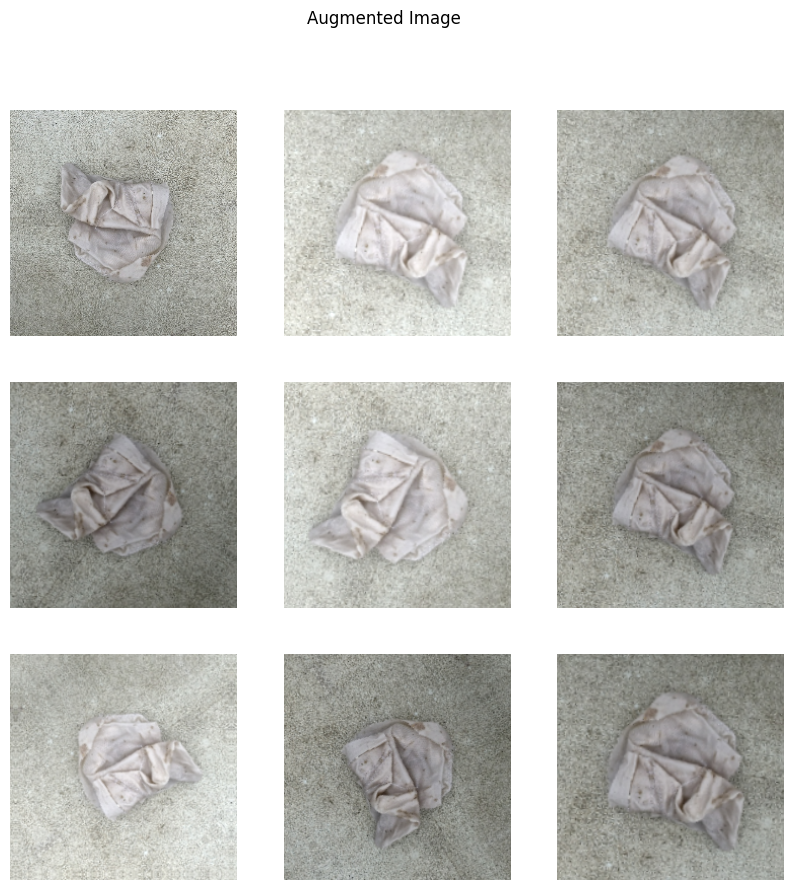

In [9]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [10]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [11]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [12]:

# 1. Shuffle once with seed BEFORE splitting
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

# 2. Split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# 3. Perform split
train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)


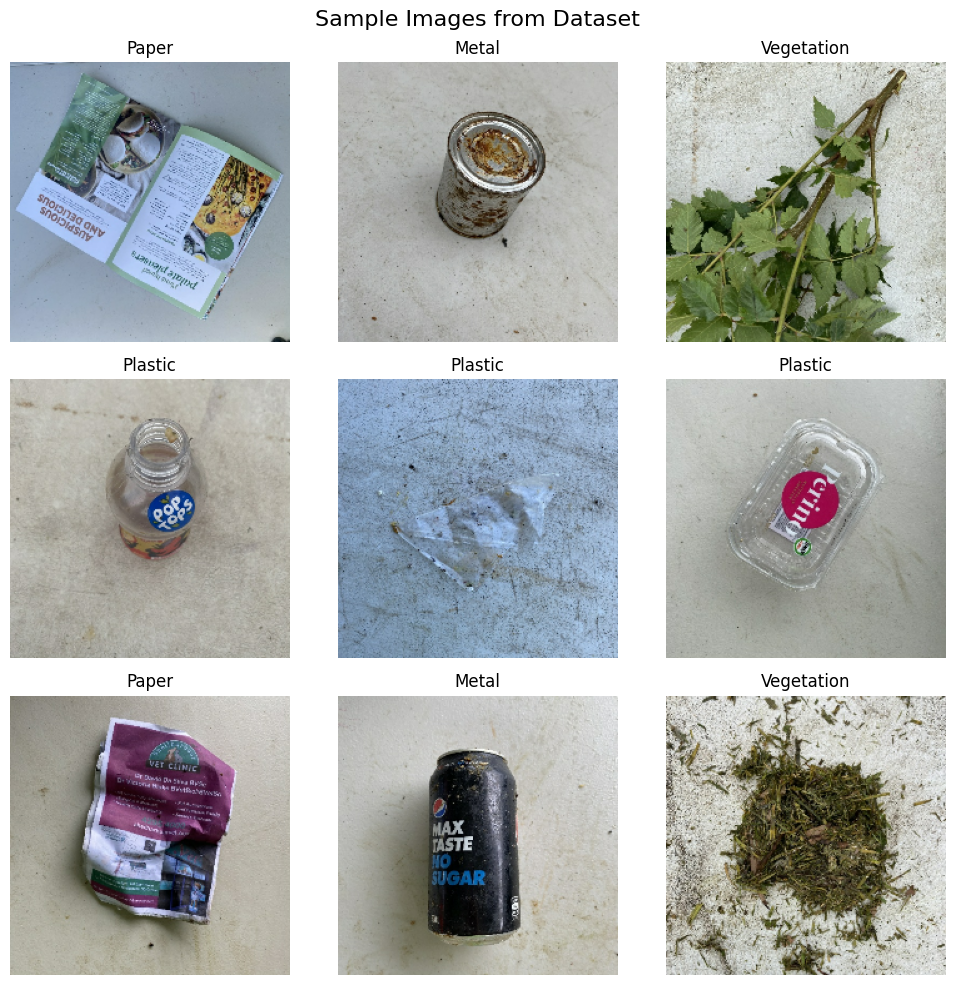

In [13]:


plt.figure(figsize=(10, 10))

    # Take 1 batch
for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]         # Extract one image from the batch
    label_idx = labels[i].numpy()  # Get class index

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # Convert to displayable format
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()



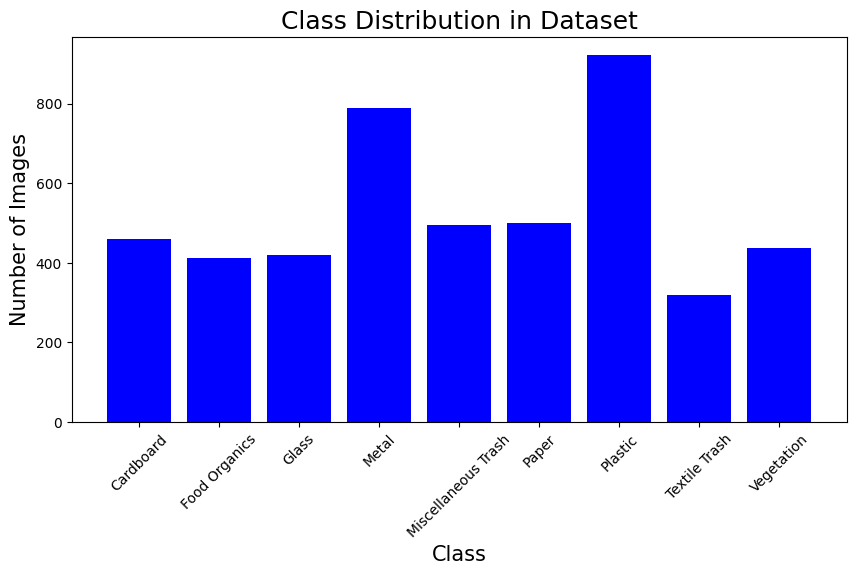

In [14]:

class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [15]:
label_extraction_ds = dataset.shuffle(buffer_size=dataset_size, seed=42).take(train_size)
label_extraction_ds = label_extraction_ds.unbatch().batch(256)

train_labels = []

for batch in label_extraction_ds:
    _, labels = batch

    if tf.rank(labels).numpy() > 1:
        labels = tf.argmax(labels, axis=1)

    train_labels.extend(labels.numpy())

train_labels = np.array(train_labels)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)




Class weights: {0: np.float64(1.160883280757098), 1: np.float64(1.3003533568904593), 2: np.float64(1.2777777777777777), 3: np.float64(0.6630630630630631), 4: np.float64(1.0823529411764705), 5: np.float64(1.0887573964497042), 6: np.float64(0.5618320610687023), 7: np.float64(1.5862068965517242), 8: np.float64(1.2105263157894737)}


In [25]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss_val = weight * cross_entropy
        return K.sum(loss_val, axis=1)
    return loss

In [31]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:

        return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(scheduler)

In [32]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [37]:

model = models.Sequential([
    Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=categorical_focal_loss(),
                  metrics=['accuracy'])




In [38]:
history = model.fit(train_dataset, epochs=35, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[lr_scheduler])

Epoch 1/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 59s 435ms/step - accuracy: 0.1144 - loss: 0.7477 - val_accuracy: 0.0923 - val_loss: 0.5148 - learning_rate: 1.0000e-05
Epoch 2/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 462ms/step - accuracy: 0.1670 - loss: 0.6168 - val_accuracy: 0.0923 - val_loss: 0.5809 - learning_rate: 1.0000e-05
Epoch 3/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 460ms/step - accuracy: 0.2205 - loss: 0.5529 - val_accuracy: 0.1491 - val_loss: 0.6463 - learning_rate: 1.0000e-05
Epoch 4/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 461ms/step - accuracy: 0.2196 - loss: 0.5367 - val_accuracy: 0.1307 - val_loss: 0.6367 - learning_rate: 1.0000e-05
Epoch 5/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 461ms/step - accuracy: 0.2249 - loss: 0.5167 - val_accuracy: 0.2427 - val_loss: 0.4491 - learning_rate: 1.0000e-05
Epoch 6/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 460ms/step - accuracy: 0.2359 - loss: 0.4948 - val_accuracy: 0.2878 - val_loss: 0.3718 - learning_rate: 9.0484e-06
Epoch 7/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 45

In [40]:
model.save("my_model.keras")


In [39]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [41]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.73      0.32      0.44        60
           1       0.12      0.54      0.20        54
           2       0.88      0.46      0.61        78
           3       0.50      0.04      0.07       124
           4       0.26      0.23      0.24        70
           5       0.45      0.63      0.52        76
           6       0.54      0.22      0.31       133
           7       0.24      0.13      0.17        45
           8       0.39      0.84      0.54        64

    accuracy                           0.34       704
   macro avg       0.46      0.38      0.34       704
weighted avg       0.48      0.34      0.33       704



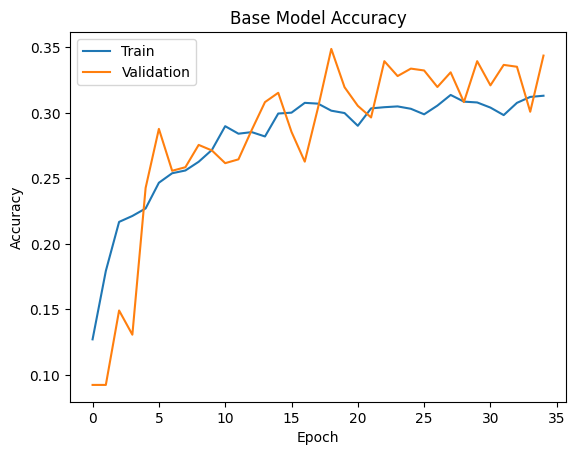

In [42]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

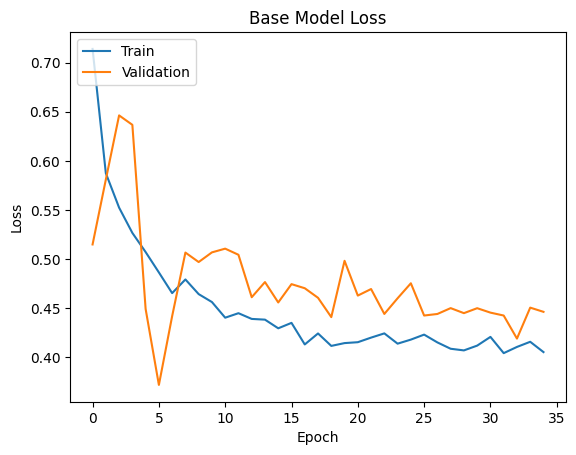

In [43]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

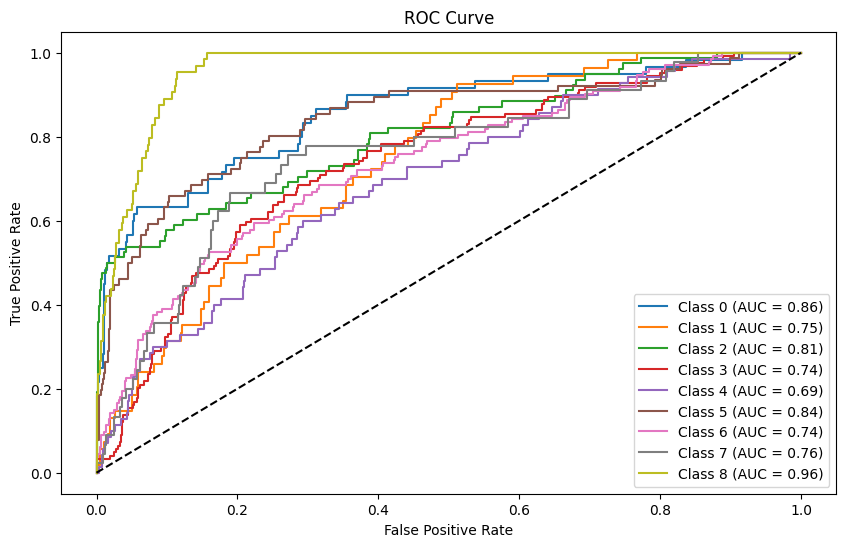

In [44]:

num_classes = 9
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

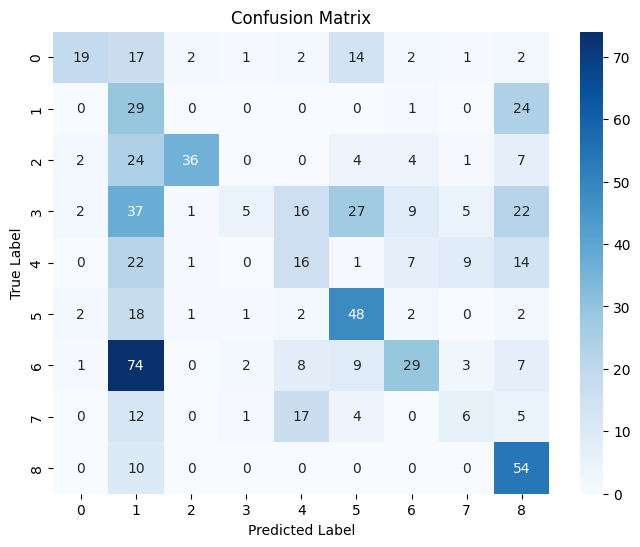

In [45]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [46]:

test_loss_base, test_acc_base = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.3241 - loss: 0.4539
Test Accuracy: 0.3315
Test Loss: 0.4396


In [47]:
import keras_tuner as kt
from tensorflow.keras import layers, models

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(224, 224, 3)))
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=3,
        activation='relu'

    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=512, step=64),
        kernel_size=3,
        activation='relu'

    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(hp.Int("units", min_value=64, max_value=512, step=64)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1)))
    model.add(layers.Dense(9, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [48]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_tuning',
    project_name='cnn_baseline'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10)


Trial 5 Complete [00h 09m 56s]
val_accuracy: 0.4332386255264282

Best val_accuracy So Far: 0.4588068127632141
Total elapsed time: 00h 48m 59s


In [49]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [50]:
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[lr_scheduler,reduce_lr]
)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 467ms/step - accuracy: 0.2055 - loss: 2.5902 - val_accuracy: 0.1009 - val_loss: 2.4262 - learning_rate: 0.0010
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 467ms/step - accuracy: 0.3570 - loss: 1.9834 - val_accuracy: 0.1335 - val_loss: 2.5946 - learning_rate: 0.0010
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 57s 467ms/step - accuracy: 0.4040 - loss: 1.7604 - val_accuracy: 0.0739 - val_loss: 2.9127 - learning_rate: 0.0010
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.3777 - loss: 1.7491
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 465ms/step - accuracy: 0.3779 - loss: 1.7487 - val_accuracy: 0.1804 - val_loss: 2.5464 - learning_rate: 0.0010
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 467ms/step - accuracy: 0.4327 - loss: 1.5906 - val_accuracy: 0.2315 - val_loss: 2.2111 - learning_rate: 5.0000e-04
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 58s 481ms/step - accuracy: 0

In [51]:
best_model.save("my_model.keras")

In [52]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [53]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.33      0.58      0.42        65
           1       0.57      0.35      0.43        69
           2       0.73      0.62      0.67        58
           3       0.56      0.72      0.63       100
           4       0.31      0.17      0.22        70
           5       0.52      0.79      0.63        77
           6       0.56      0.44      0.49       140
           7       0.80      0.09      0.16        45
           8       0.43      0.56      0.49        64

    accuracy                           0.50       688
   macro avg       0.54      0.48      0.46       688
weighted avg       0.53      0.50      0.48       688



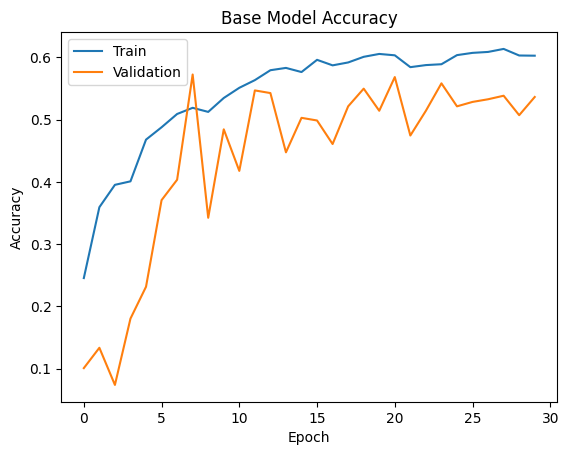

In [54]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

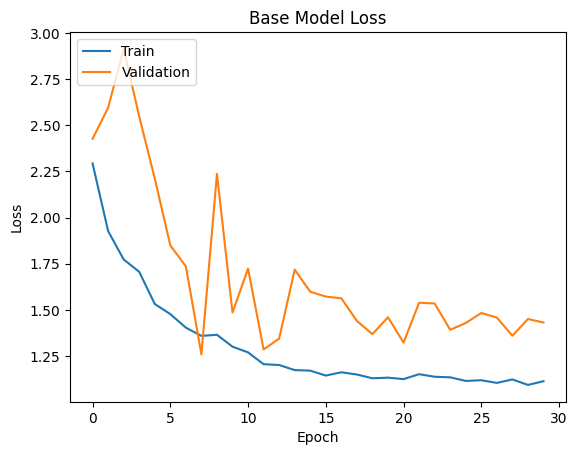

In [55]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

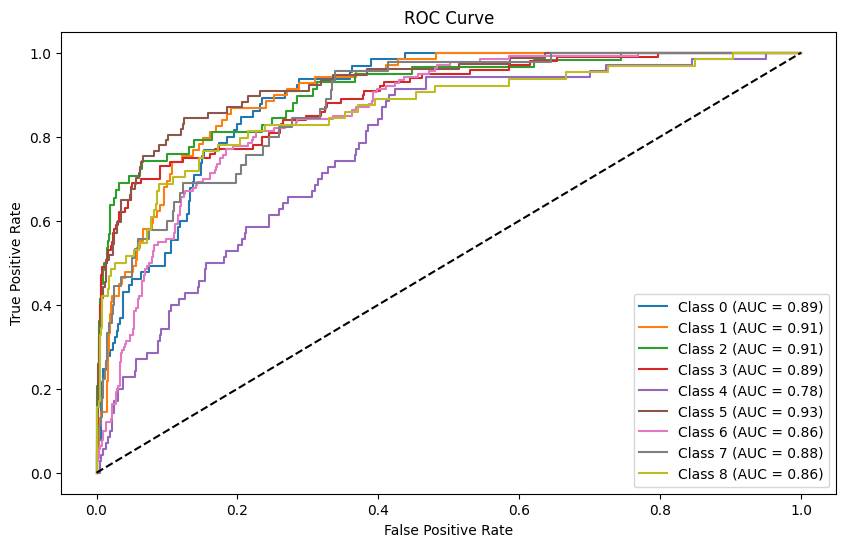

In [56]:

num_classes = 9
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

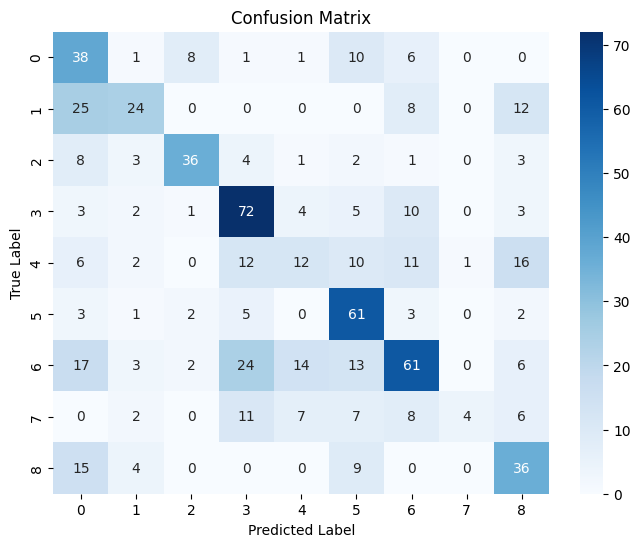

In [57]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [58]:

def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            pred_label = np.argmax(predictions[i])

            ax = plt.subplot(3, 3, i + 1)  # 3x3 grid for 9 images
            plt.imshow((image * 255).numpy().astype("uint8"))  # Denormalize
            plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", fontsize=10)
            plt.axis("off")

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


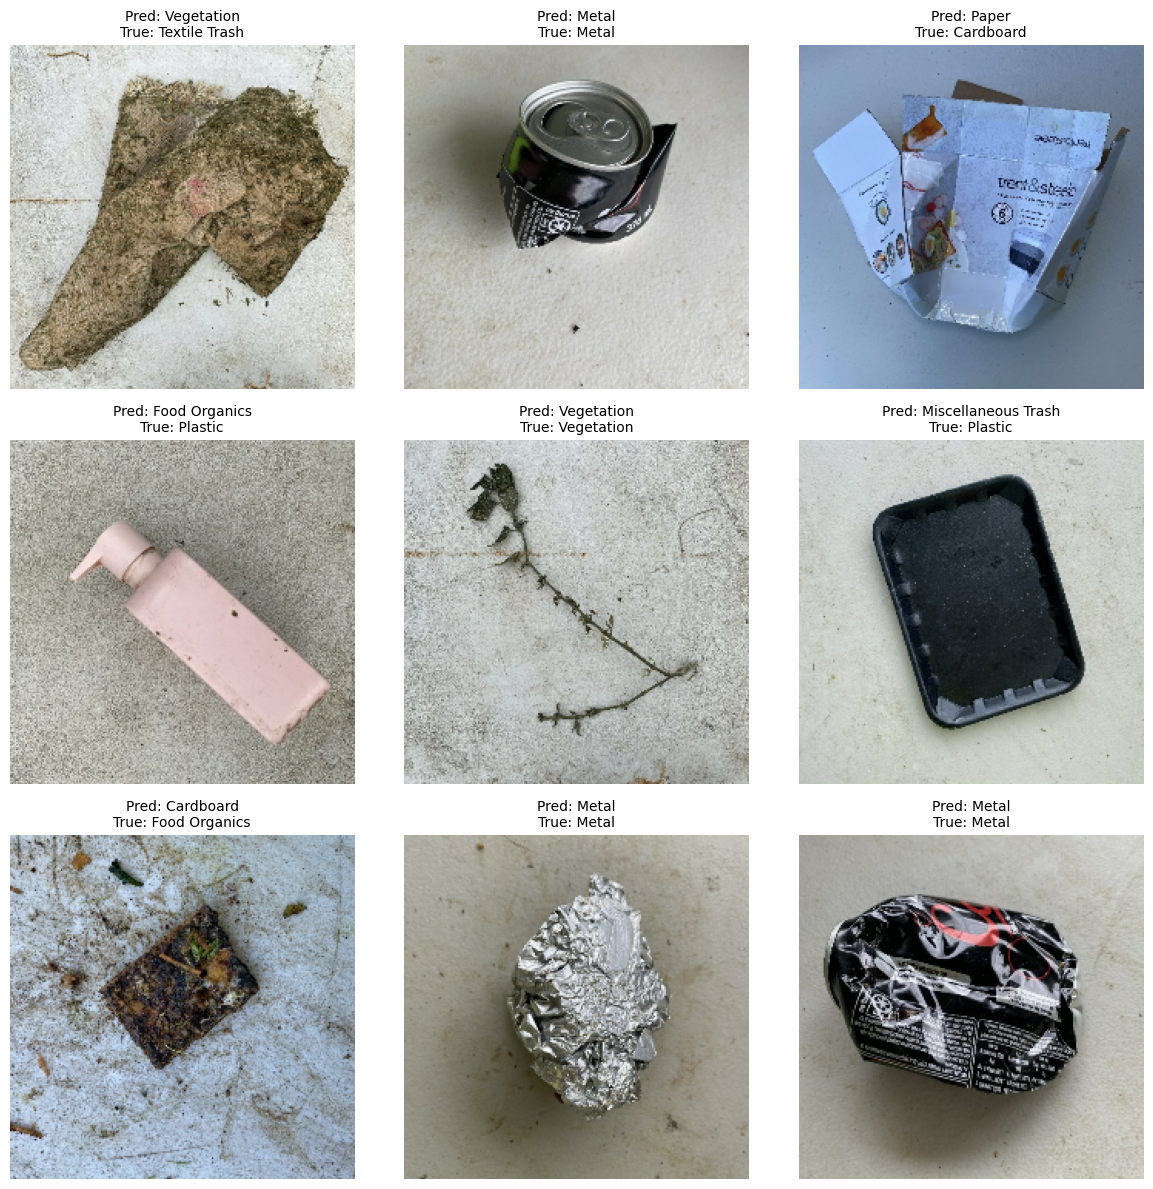

In [61]:
classify_from_dataset(best_model, test_dataset, class_names)

In [76]:

from tensorflow.keras.models import load_model

# Make sure the custom focal loss is registered again
@tf.keras.utils.register_keras_serializable()
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.keras.backend.log(y_pred)
        weight = alpha * tf.keras.backend.pow(1 - y_pred, gamma)
        return tf.keras.backend.sum(weight * cross_entropy, axis=1)
    return loss

# Load your trained model
model = load_model("my_model.keras", custom_objects={'categorical_focal_loss': categorical_focal_loss()})


In [81]:
# 1. Run a dummy input to build the model
_ = model(tf.zeros((1, 224, 224, 3)))

# 2. Create the feature extractor from the second-last dense layer (Dense with 64 units)
# Use -4 because the layers are:
# [-1] Dense(9), [-2] Dropout, [-3] BatchNorm, [-4] Dense(64) ← This is what we want
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

AttributeError: The layer sequential_1 has never been called and thus has no defined input.

In [74]:
_ = model(tf.random.normal([1, 224, 224, 3]))

In [75]:
from tensorflow.keras.models import Model
feature_extractor = Model(
    inputs=model.input,
    outputs=model.get_layer('feature_layer').output
)

AttributeError: The layer sequential_5 has never been called and thus has no defined input.

In [ ]:
def extract_features(dataset, feature_model):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        batch_features = feature_model.predict(batch_images)
        features.append(batch_features)
        labels.append(np.argmax(batch_labels.numpy(), axis=1))  # Convert one-hot to label

    return np.vstack(features), np.concatenate(labels)

In [64]:
X_train, y_train = extract_features(train_dataset, feature_extractor)
X_test, y_test = extract_features(test_dataset, feature_extractor)

NameError: name 'extract_features' is not defined

In [ ]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Evaluate
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=class_names))